주가예측

In [ ]:
!pip install pandas-datareader
!pip install yfinance

In [43]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

In [44]:
print(torch.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

2.1.2+cu121
Populating the interactive namespace from numpy and matplotlib


# Data Preparation

In [45]:
import yfinance as yfin
yfin.pdr_override()

google = pdr.get_data_yahoo('028050.KS', start='2000-12-01', end='2023-12-23') # 삼성엔지니어링 주식
print(type(google))
google.tail()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-18,26700.0,26750.0,26250.0,26250.0,26250.0,629535
2023-12-19,26100.0,27350.0,26100.0,27200.0,27200.0,580338
2023-12-20,27400.0,28250.0,27350.0,28000.0,28000.0,717824
2023-12-21,27600.0,27900.0,27350.0,27600.0,27600.0,441640
2023-12-22,27900.0,28750.0,27850.0,28350.0,28350.0,787827


<AxesSubplot:xlabel='Date'>

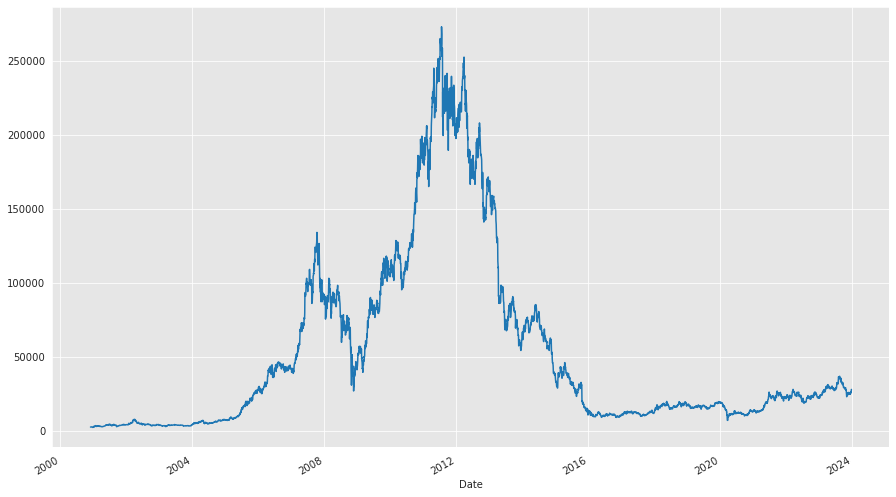

In [46]:
google.Low.plot(grid=True)

In [47]:
print(google.isna().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


### * 데이터셋 만들어보기

In [ ]:
class dummySet(Dataset):
    def __init__(self, num_data):
        self.x = np.array(list(range(num_data*2))).reshape(-1, 2)
        self.y = np.array(list(range(num_data)))
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = dummySet(100)
print(dataset.x)
print(len(dataset))
print(dataset[0])
        

In [ ]:
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)

for batch in dataloader: # 중복 없이 batch_size만큼 데이터를 뽑아옴
    X = batch[0]
    y = batch[1]
    print(batch)

In [49]:
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames # sequence : 최근 n일 간의 데이터
        self.y_frames = y_frames # target : 다음 m일 간의 데이터
        
        self.start = datetime.date(*start)
        self.end = datetime.date(*end)

        self.data = pdr.get_data_yahoo(self.symbol, self.start, self.end)  #pdr.DataReader(self.symbol, 'yahoo', self.start, self.end)
        print(self.data.isna().sum())
        
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    def __getitem__(self, idx): # indexing
        idx += self.x_frames
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close', 'Adj Close', 'Volume']]
        data = data.apply(lambda x: np.log(x+1) - np.log(x.iloc[self.x_frames-1]+1)) # 변동 추이를 보기 위해 비율로 변환
        data = data.values # dataframe -> numpy array로 변환
        X = data[:self.x_frames]
        y = data[self.x_frames:]
        
        return X, y

In [50]:
dataset = StockDataset('028050.KS', 10, 5, (2001, 1, 1), (2005, 1, 1))
dataloader = DataLoader(dataset, batch_size=3, shuffle=False)
for X, y in dataloader:
    print(X.shape, y.shape)
    break

[*********************100%%**********************]  1 of 1 completed

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
torch.Size([3, 10, 6]) torch.Size([3, 5, 6])


# Model Architecture

* Add information flow? -> Cell State!
남길 건 남기고, 잊어버릴 건 잊어버리고, 새로 추가할 건 추가해서 Cell State에 중요한 정보만 계속 흘러가도록!
* Hidden State는 Cell State를 적당히 가공해서 내보내자! -> Gate! : element wise coefficient multiplication
    - f : forget gate (불필요한 정보 지우기)
    - i : input gate (중요한 정보 넣기)
    - C_t : Cell State (업데이트) ; without passing non-linear activation function
    - o_t : output gate (hidden state 계산)

In [51]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self): # hidden -> output by mlp
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        #print('x',x.shape)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        #print(type(lstm_out),type(self.hidden))
        #print('output',lstm_out.shape, self.hidden[0].shape, self.hidden[1].shape)
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        #print('y_pred',y_pred.shape)
        return y_pred

In [52]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy()) # 원래 스케일로 변환
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

# Experiment Preparation

In [53]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'], 
                             batch_size=args.batch_size, 
                             shuffle=True, drop_last=True)
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    train_acc = 0.0
    train_loss = 0.0
    for i, (X, y) in enumerate(trainloader):
        #print('raw', X.shape, y.shape)

        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device) # 3 : Close Price (종가)
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        #print('processed', X.shape, y_true.shape)
        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc

In [54]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [55]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [56]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [57]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [58]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

# Experiment

In [59]:
# ====== Random Seed Initialization ====== #
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp3_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 128
args.x_frames = 5
args.y_frames = 5

In [60]:
trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2012,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2012,1,1), (2016,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [61]:
# ====== Model Capacity ===== #
args.input_dim = 6
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 10


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]


for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(exp_name='exp3_lr', device='cuda', symbol='028050.KS', batch_size=128, x_frames=5, y_frames=5, input_dim=6, hid_dim=50, n_layers=1, l2=1e-05, dropout=0.0, use_bn=True, optim='RMSprop', lr=0.001, epoch=10)
Epoch 0, Acc(train/val): 16.52/13.42, Loss(train/val) 0.02649/0.01031. Took 4.55 sec
Epoch 1, Acc(train/val): 5.76/8.51, Loss(train/val) 0.00465/0.00556. Took 4.57 sec
Epoch 2, Acc(train/val): 3.70/3.00, Loss(train/val) 0.00404/0.00311. Took 4.52 sec
Epoch 3, Acc(train/val): 3.01/2.35, Loss(train/val) 0.00358/0.00256. Took 4.53 sec
Epoch 4, Acc(train/val): 2.94/2.15, Loss(train/val) 0.00376/0.00246. Took 4.51 sec
Epoch 5, Acc(train/val): 2.83/2.14, Loss(train/val) 0.00347/0.00261. Took 4.52 sec
Epoch 6, Acc(train/val): 2.78/2.13, Loss(train/val) 0.00341/0.00275. Took 4.54 sec
Epoch 7, Acc(train/val): 2.73/2.02, Loss(train/val) 0.00340/0.00246. Took 4.64 sec
Epoch 8, Acc(train/val): 2.85/2.20, Loss(train/val) 0.00349/0.00260. Took 4.55 sec
Epoch 9, Acc(train/val): 2.83/2.19, 

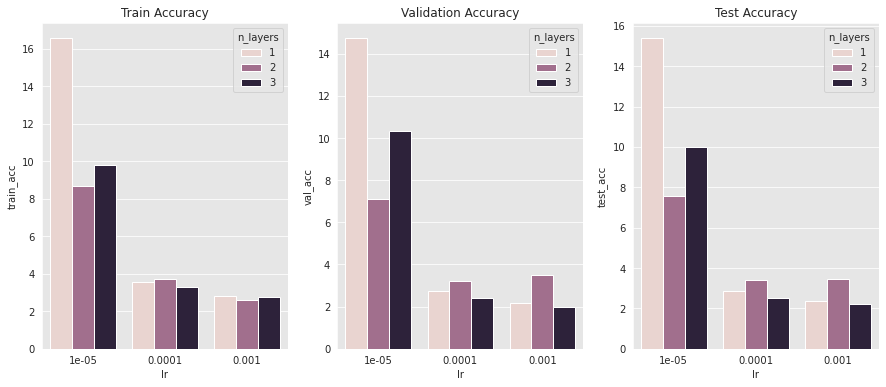

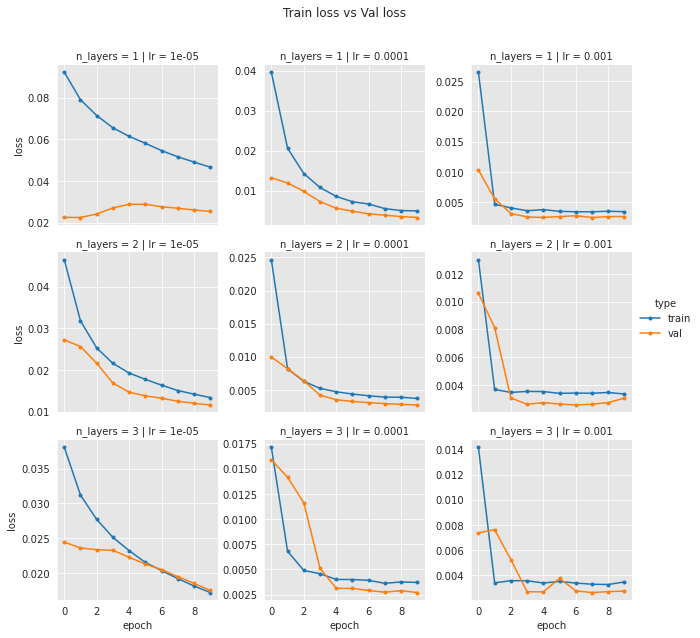

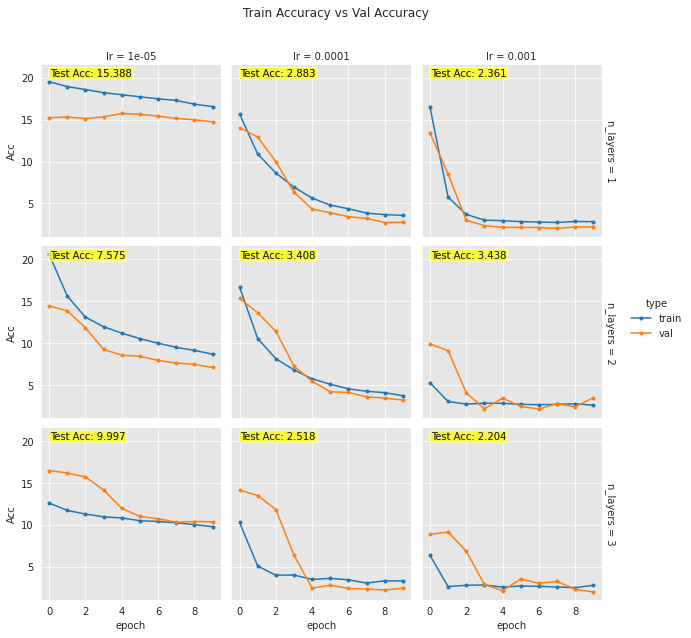

In [62]:
var1 = 'lr'
var2 = 'n_layers'
df = load_exp_result('exp3')

plot_acc(var1, var2, df)
plot_loss_variation(var1, var2, df, sharey=False) #sharey를 True로 하면 모든 subplot의 y축의 스케일이 같아집니다.
plot_acc_variation(var1, var2, df, margin_titles=True, sharey=True)